In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
from salishsea_tools import tidetools, geo_tools, viz_tools, nc_tools
import pytz
from matplotlib.colors import LogNorm
import os
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [2]:
import h5py

In [3]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

In [4]:
plt.style.use('/ocean/vdo/MEOPAR/biomodelevalpaper/bioModelEvalPaper.mplstyle')

In [5]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [6]:
filepath = '/ocean/eolson/MEOPAR/obs/Hakai/SentryShoal/Full_SUNA_Processed.mat'

In [7]:
arrays = {}
f = h5py.File(filepath)
for k, v in f.items():
    arrays[k] = np.array(v)

In [8]:
dates = arrays['Full_SUNA_Processed'][0,:]
times = arrays['Full_SUNA_Processed'][1,:]
temps = arrays['Full_SUNA_Processed'][2,:]
sals = arrays['Full_SUNA_Processed'][3,:]
nitrate = arrays['Full_SUNA_Processed'][5,:]

In [9]:
datenumber = arrays['Full_SUNA_Processed'][-1, :]

In [10]:
base = datetime.datetime(2000, 1, 1)
py_times = np.array([base for i in range(63721)])
for n in range(63721):
    py_times[n] = ((datetime.datetime.fromordinal(int(datenumber[n])))
                       + datetime.timedelta(days=datenumber[n]%1)
                       - datetime.timedelta(days = 366))

In [11]:
#load model grid stuff
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [12]:
geo_tools.find_closest_model_point(-124 - 59/60, 
                                                    49 + 54.4/60, 
                                                    X, Y, 
                                                    land_mask = bathy.mask)

(703, 146)

In [14]:
h = nc.Dataset('/results/SalishSea/hindcast.201905/01jan18/SalishSea_1d_20180101_20180101_dia2_T.nc')

In [15]:
HINDCAST_PATH = '/results/SalishSea/hindcast.201905/'

In [16]:
list_of_model_ni = np.array([])

depth = 0
Yind, Xind = [703, 146]

for n in range(63721):
    date = py_times[n]
    sub_dir = date.strftime('%d%b%y').lower()
    datestr = date.strftime('%Y%m%d')
    fname = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr, datestr)
    nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
    if date.minute < 30:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                           hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
    if date.minute >= 30:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30)
    after = before + datetime.timedelta(hours=1)
    sub_dir2 = after.strftime('%d%b%y').lower()
    datestr2 = after.strftime('%Y%m%d')
    fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
    nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
    delta = (date.minute) / 60
    ni_val = (delta*(nuts.variables['nitrate'][before.hour, depth, Yind, Xind] ) + 
               (1- delta)*(nuts2.variables['nitrate'][after.hour, depth, Yind, Xind] ))
    list_of_model_ni = np.append(list_of_model_ni, ni_val)

In [17]:
list_of_model_ni.shape

(63721,)

In [18]:
nitrate2 = np.ma.masked_invalid(nitrate)
list_of_model_ni2 = np.ma.masked_array(list_of_model_ni, mask = nitrate2.mask)

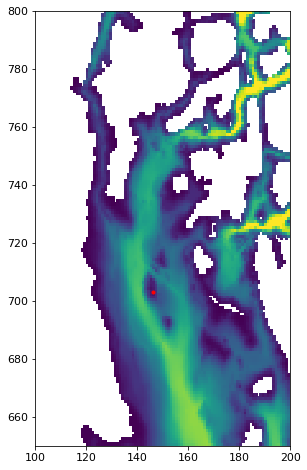

In [19]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.pcolormesh(grid.variables['Bathymetry'][:])
ax.plot(Xind, Yind, 'r.')
ax.set_ylim(650, 800)
ax.set_xlim(100, 200)
viz_tools.set_aspect(ax);

In [20]:
np.ma.count(nitrate2)

60951

bias =  1.085771491179841
RMSE = 5.602387954828431
Willmott = 0.8703021621709537


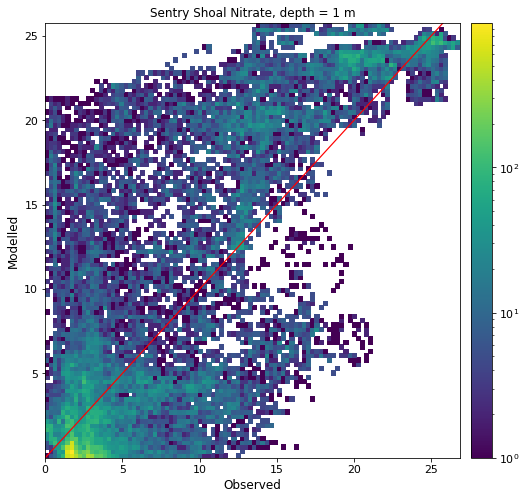

In [21]:
fig, ax = plt.subplots(figsize = (8, 8))
c, xedge, yedge, im = ax.hist2d(nitrate2.compressed(), list_of_model_ni2.compressed(), 
                                     bins = 100, norm=LogNorm());
ax.plot(np.arange(0,30), np.arange(0,30), color = 'red')
ax.set_title('Sentry Shoal Nitrate, depth = 1 m')
ax.set_xlabel('Observed')
ax.set_ylabel('Modelled')
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.15)
cbar = plt.colorbar(im, cax = cax1)
print('bias =  ' + str(-np.mean(nitrate2) + np.mean(list_of_model_ni2)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni2 - nitrate2)**2) /
                              np.ma.count(nitrate2))))
xbar = np.mean(nitrate2)
print('Willmott = ' + str(1-(np.sum((list_of_model_ni2 - nitrate2)**2)  / 
                             np.sum((np.abs(list_of_model_ni2 - xbar) 
                                     + np.abs(nitrate2 - xbar))**2))))

/home/vdo/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


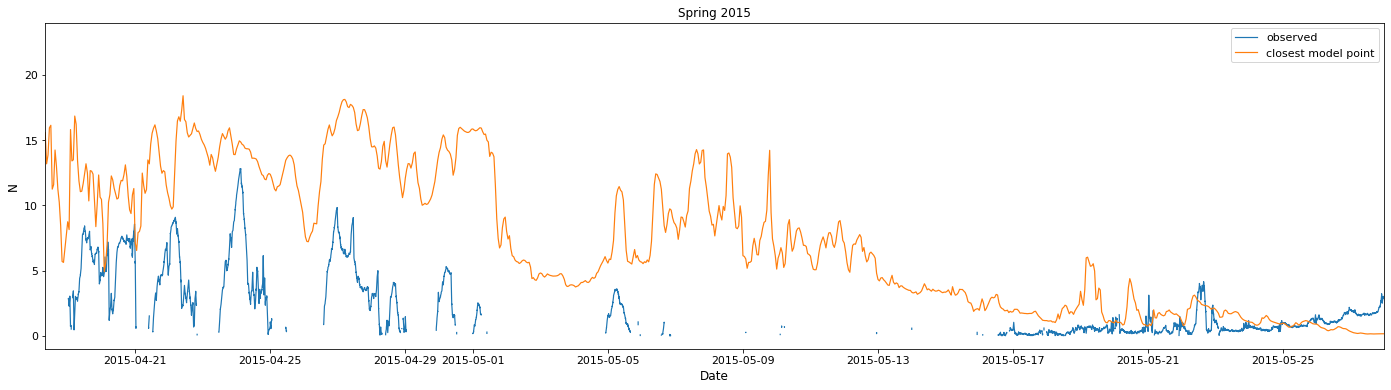

In [22]:
fig, ax = plt.subplots(figsize = (24, 6))
ax.plot(py_times, nitrate2, label = 'observed')
ax.plot(py_times, list_of_model_ni, label = 'closest model point')
ax.set_title('Spring 2015')
ax.set_xlabel('Date')
ax.set_xlim(py_times[0], datetime.datetime(2015,5,28))
ax.legend()
ax.set_ylim(-1, 24)
ax.set_ylabel('N');

In [23]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

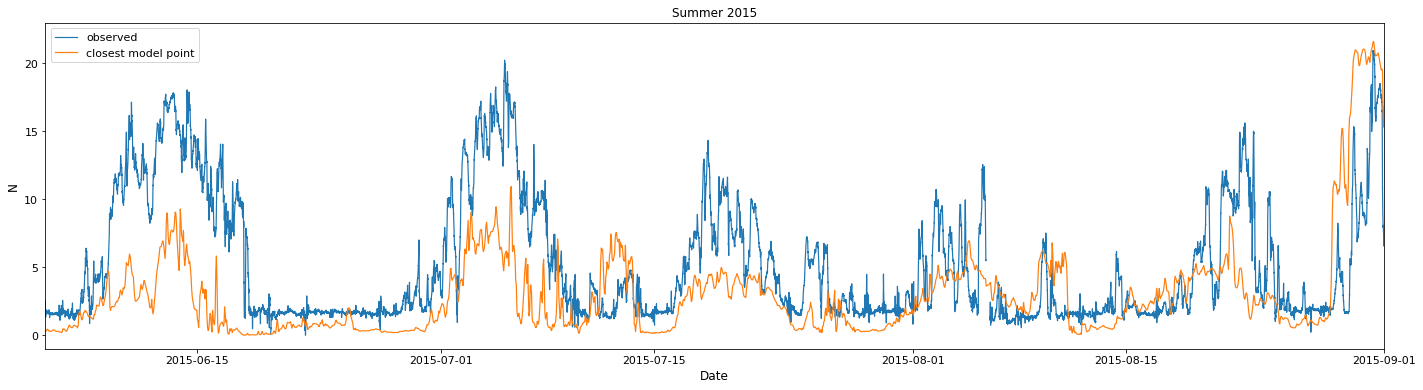

In [24]:
fig, ax = plt.subplots(figsize = (24, 6))
ax.plot(py_times, nitrate2, label = 'observed')
ax.plot(py_times, list_of_model_ni, label = 'closest model point')
ax.set_title('Summer 2015')
ax.set_xlabel('Date')
ax.set_xlim(datetime.datetime(2015,6,5), datetime.datetime(2015,9,1))
ax.legend()
ax.set_ylim(-1, 23)
ax.set_ylabel('N');

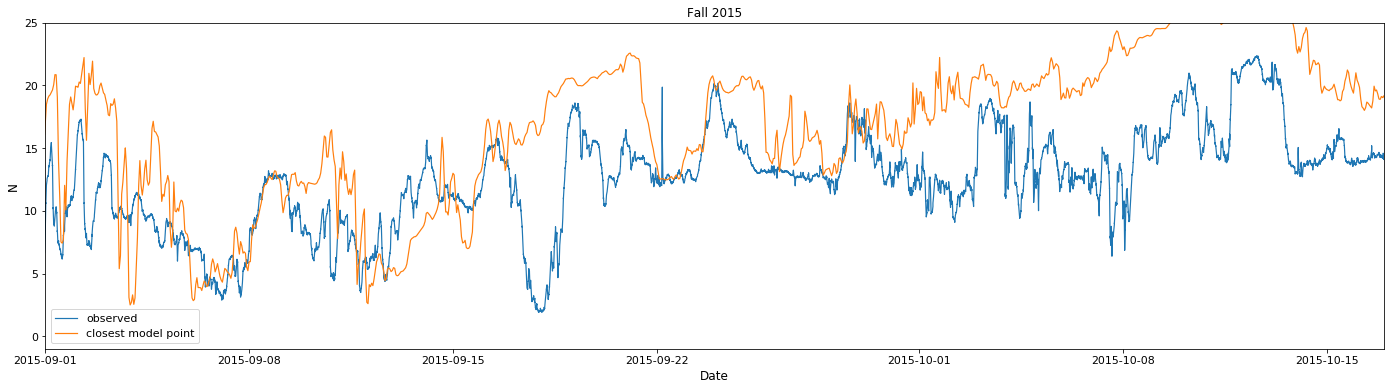

In [25]:
fig, ax = plt.subplots(figsize = (24, 6))
ax.plot(py_times, nitrate2, label = 'observed')
ax.plot(py_times, list_of_model_ni, label = 'closest model point')
ax.set_title('Fall 2015')
ax.set_xlabel('Date')
ax.set_xlim(datetime.datetime(2015,9,1), py_times[37652])
ax.legend()
ax.set_ylim(-1, 25)
ax.set_ylabel('N');

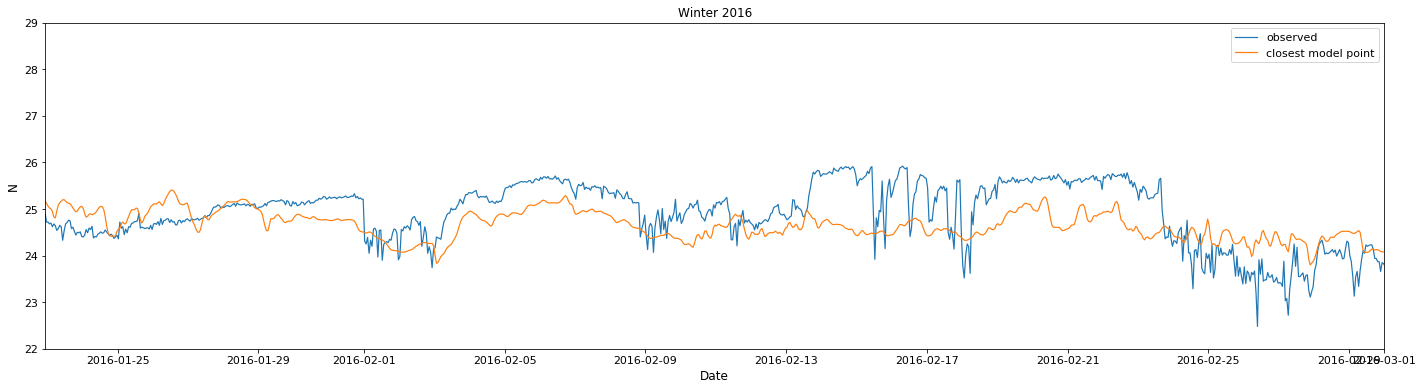

In [26]:
fig, ax = plt.subplots(figsize = (24, 6))
ax.plot(py_times, nitrate2, label = 'observed')
ax.plot(py_times, list_of_model_ni, label = 'closest model point')
ax.set_title('Winter 2016')
ax.set_xlabel('Date')
ax.set_xlim(py_times[37653], datetime.datetime(2016,3,1))
ax.legend()
ax.set_ylim(22, 29)
ax.set_ylabel('N');

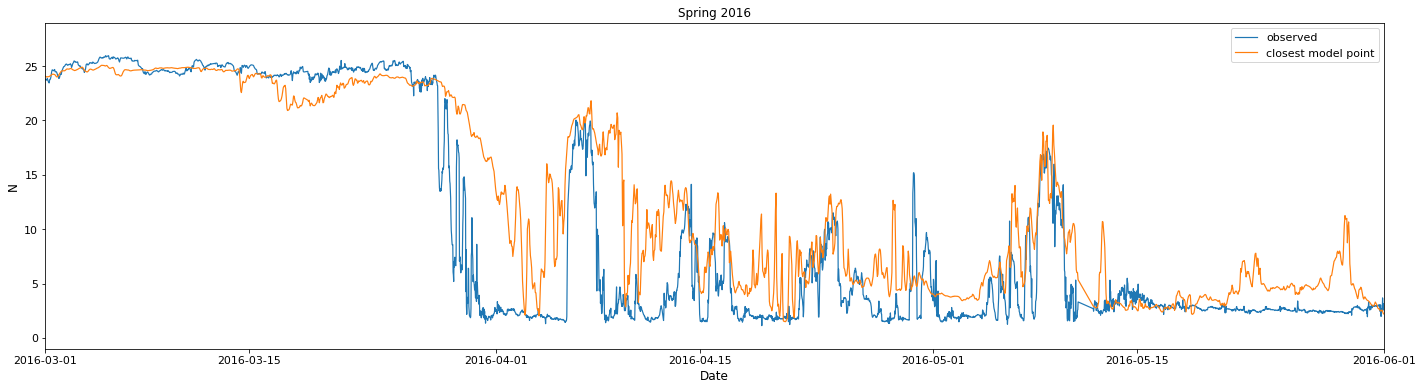

In [27]:
fig, ax = plt.subplots(figsize = (24, 6))
ax.plot(py_times, nitrate2, label = 'observed')
ax.plot(py_times, list_of_model_ni, label = 'closest model point')
ax.set_title('Spring 2016')
ax.set_xlabel('Date')
ax.set_xlim(datetime.datetime(2016,3,1), datetime.datetime(2016,6,1))
ax.legend()
ax.set_ylim(-1, 29)
ax.set_ylabel('N');

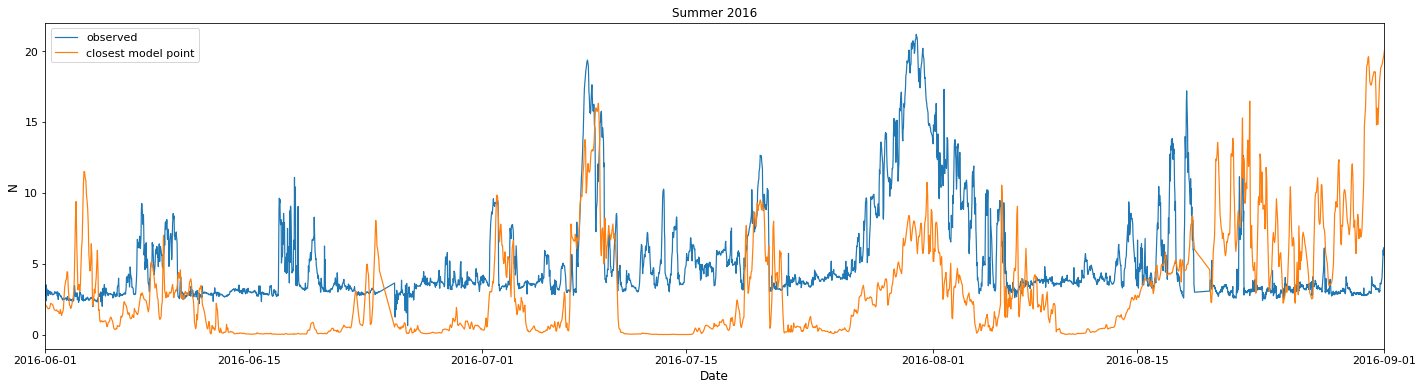

In [28]:
fig, ax = plt.subplots(figsize = (24, 6))
ax.plot(py_times, nitrate2, label = 'observed')
ax.plot(py_times, list_of_model_ni, label = 'closest model point')
ax.set_title('Summer 2016')
ax.set_xlabel('Date')
ax.set_xlim(datetime.datetime(2016,6,1), datetime.datetime(2016,9,1))
ax.legend()
ax.set_ylim(-1, 22)
ax.set_ylabel('N');

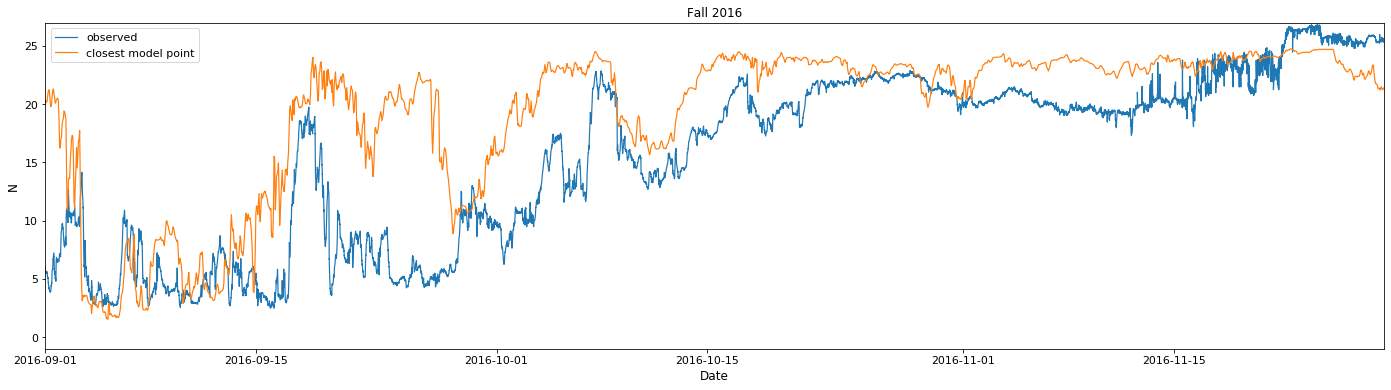

In [29]:
fig, ax = plt.subplots(figsize = (24, 6))
ax.plot(py_times, nitrate2, label = 'observed')
ax.plot(py_times, list_of_model_ni, label = 'closest model point')
ax.set_title('Fall 2016')
ax.set_xlabel('Date')
ax.set_xlim(datetime.datetime(2016,9,1), datetime.datetime(2016,11,29))
ax.legend()
ax.set_ylim(-1, 27)
ax.set_ylabel('N');

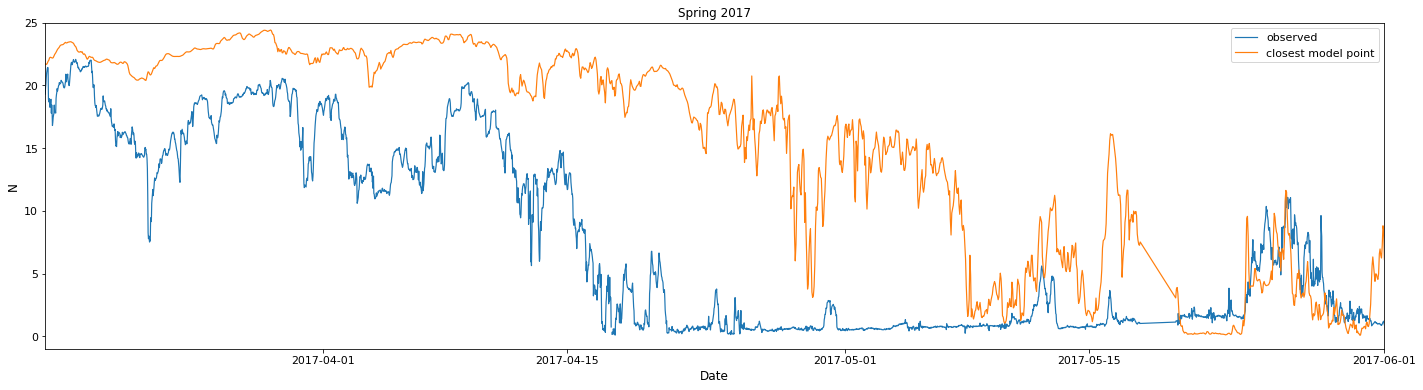

In [30]:
fig, ax = plt.subplots(figsize = (24, 6))
ax.plot(py_times, nitrate2, label = 'observed')
ax.plot(py_times, list_of_model_ni, label = 'closest model point')
ax.set_title('Spring 2017')
ax.set_xlabel('Date')
ax.set_xlim(py_times[55684], datetime.datetime(2017,6,1))
ax.legend()
ax.set_ylim(-1, 25)
ax.set_ylabel('N');

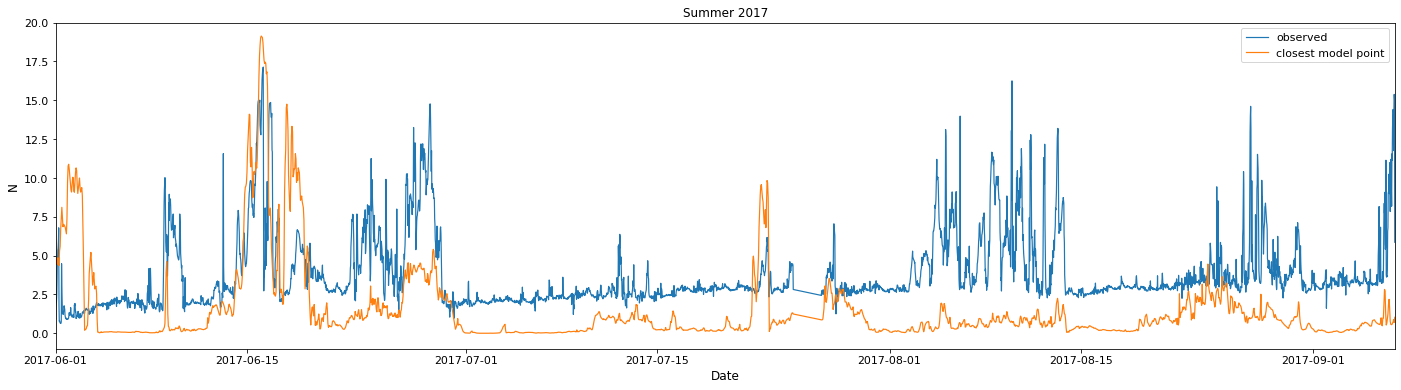

In [31]:
fig, ax = plt.subplots(figsize = (24, 6))
ax.plot(py_times, nitrate2, label = 'observed')
ax.plot(py_times, list_of_model_ni, label = 'closest model point')
ax.set_title('Summer 2017')
ax.set_xlabel('Date')
ax.set_xlim(datetime.datetime(2017,6,1), py_times[-1])
ax.legend()
ax.set_ylim(-1, 20)
ax.set_ylabel('N');